参考サイト：https://www.dpac.dpri.kyoto-u.ac.jp/enomoto/pymetds/Lorenz.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def florenz(w, p, r, b):
    x, y, z = w
    dw = np.zeros_like(w)
    dw[0] =      -p * x + p * y 
    dw[1] = (r - z) * x -     y 
    dw[2] =           x * y     - b * z
    return dw

In [3]:
p, r, b, dt = 10, 32, 8/3, 0.01
nstop = 500

w1 = np.zeros([nstop+1, 3])
w2 = np.zeros([nstop+1, 3])
w1[0, :] = 1, 3, 5
w2[0, :] = 1.1, 3.3, 5.5
for i in range(nstop):
    w1[i+1, :] = w1[i, :] + dt * florenz(w1[i, :], p, r, b)
    w2[i+1, :] = w2[i, :] + dt * florenz(w2[i, :], p, r, b)    

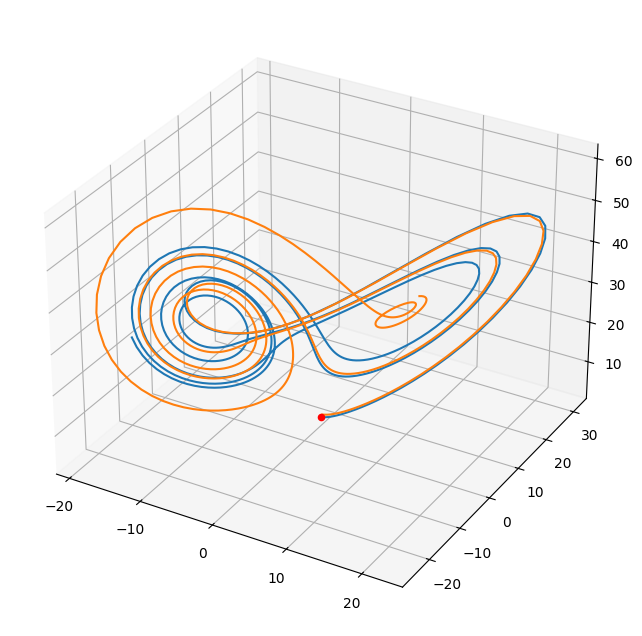

In [4]:
fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(projection="3d")
ax.scatter(*w1[0, :], c="red")
ax.plot(*w1.transpose())
ax.plot(*w2.transpose())
plt.show()

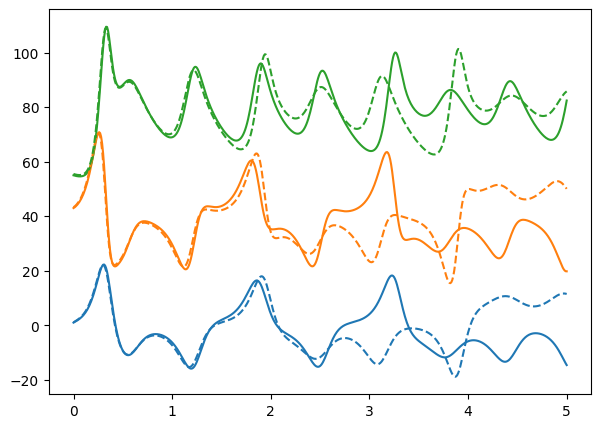

In [5]:
off1, off2 = 40, 50

x = np.linspace(0, dt*nstop, nstop+1)
w = np.copy(w1)
w[:, 1] += off1
w[:, 2] += off2
fig, ax = plt.subplots(figsize=[7,5])
ax.plot(x, w)
plt.gca().set_prop_cycle(None)
w = np.copy(w2)
w[:, 1] += off1
w[:, 2] += off2
ax.plot(x, w, linestyle="--")
plt.show()

In [32]:
def tlorenz(wt, wb, p, r, b):
    dw = np.zeros_like(wt)
    xt, yt, zt = wt
    xb, yb, zb = wb
    dw[0] =       -p * xt +  p * yt 
    dw[1] = (r - zb) * xt -      yt - xb * zt
    dw[2] =       yb * xt + xb * yt -  b * zt
    return dw

In [33]:
def alorenz(wa, dwa, wb, p, r, b):
    xb, yb, zb = wb
    dxa, dya, dza = dwa
    wa[0] += -p * dxa + (r - zb) * dya + yb * dza
    wa[1] +=  p * dxa -            dya + xb * dza
    wa[2] +=          -       xb * dya -  b * dza
    dwa[:] = 0.0
    return wa, dwa

In [34]:
p, r, b, dt = 10, 32, 8/3, 0.01
nstop = 200
obs_int = 60

rng = np.random.default_rng()
w = np.array([1.0, 3.0, 5.0])
e = w * 0.1
x_obs = np.zeros([nstop//obs_int, w.size])
x_obs[0, :] = w
x = np.zeros([nstop+1, w.size])
for i in range(1, nstop+1):
    w += dt * florenz(w, p, r, b)
    if i % obs_int == 0:
        x_obs[i//obs_int-1, :] = w + e * rng.standard_normal(w.size)
    x[i, :] = w
np.save("xt.npy", x)

In [35]:
def run_florenz(w, xo, p, r, b):
    x = np.zeros([nstop+1, w.size])
    x[0, :] = w
    c = 0
    for i in range(1, nstop+1):
        w += dt * florenz(w, p, r, b)
        x[i, :] = w
        if i % obs_int == 0:
            c += ((w - xo[i//obs_int-1, :])**2).sum()
    c *= 0.5
    return x, c

In [36]:
niter = 100
alpha = 5e-4

w = np.array([1.1, 3.3, 5.5])
ad = np.zeros(w.size)
dad = np.zeros(w.size)
cost = np.zeros([niter])
cycles = [1, 2, 3, 5, 10, 30]

x, cost[0] = run_florenz(w, x_obs, p, r, b)

for j in range(niter):
    ad[:] = 0.0
    for i in range(nstop, 0, -1):
        if i % obs_int == 0 and i > 0:
            ad += x[i, :] - x_obs[i//obs_int-1, :]
        dad += dt * ad
        ad, dad = alorenz(ad, dad, x[i, :], p, r, b)
    w = x[0, :] - alpha * ad
    x, cost[j] = run_florenz(w, x_obs, p, r, b)
    if j+1 in cycles:
        np.save(f"x{j+1:03}.npy", x)

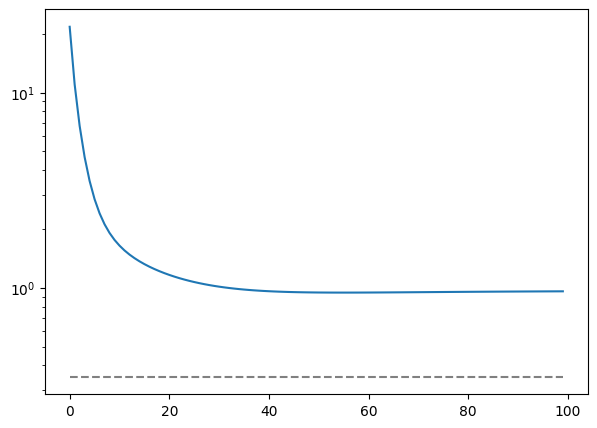

In [37]:
fig, ax = plt.subplots(figsize=[7, 5])
ax.semilogy(cost)
ax.plot([np.dot(e, e)]*cost.size, c="gray", linestyle="--")
plt.show()

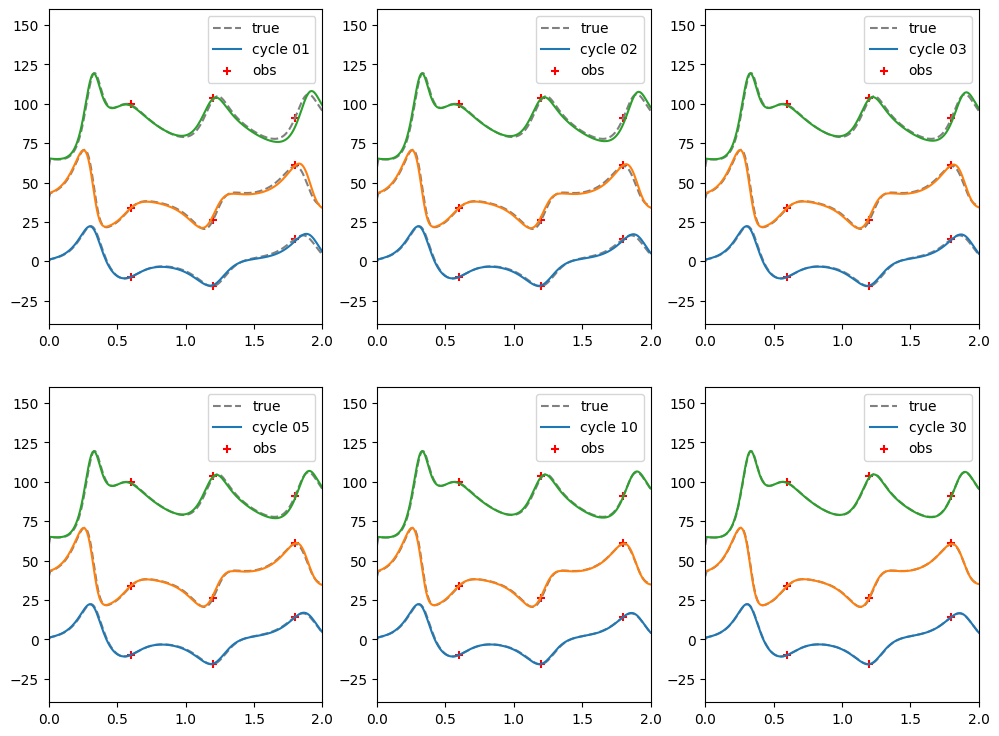

In [38]:
x = np.linspace(0, dt * nstop, nstop+1)
xobs = np.arange(obs_int, nstop, obs_int) * dt

nx, ny = 2, 3           
off1, off2 = 40, 60                              
fig, ax = plt.subplots(nx, ny, figsize=[12, 9])
wtrue = np.load("xt.npy")
wtrue[:, 1] += off1            
wtrue[:, 2] += off2
wobs = np.copy(x_obs)

wobs[:, 1] += off1
wobs[:, 2] += off2

k = 0
for ncyc in cycles:
    i, j = k // ny, k % ny
    k += 1
    w = np.load(f"x{ncyc:03}.npy")
    w[:, 1] += off1
    w[:, 2] += off2
    lines = ax[i, j].plot(x, wtrue, c="gray", linestyle="--")
    lines[0].set_label("true")
    lines = ax[i, j].plot(x, w)
    lines[0].set_label(f"cycle {ncyc:02}")
    ax[i, j].scatter(xobs, wobs[:,0], c="red", marker="+", label="obs")
    ax[i, j].scatter(xobs, wobs[:,1], c="red", marker="+")
    ax[i, j].scatter(xobs, wobs[:,2], c="red", marker="+")
    ax[i, j].set_xlim([0.0, 2.0])
    ax[i, j].set_ylim([-40, 160])
    ax[i, j].legend(loc="upper right")
    ax[i, j].set_prop_cycle(None)
plt.show()

In [39]:
def po(xf, yo, rmat, hmat):
    dx = xf - np.mean(xf, axis=1)[:, None]
    pf = dx @ dx.transpose() / (nmem - 1)
    ic = hmat @ pf @ hmat.transpose() + rmat
    kmat = pf @ hmat.transpose() @ np.linalg.inv(ic)   
    xa = xf + kmat @ (yo - hmat @ xf)
    return xa

def run_ens(xf, p, r, b, nstop):
    _, nmem = xf.shape
    for i in range(nmem):
        w = xf[:, i]
        for k in range(nstop):
            w += dt * florenz(w, p, r, b)
        xf[:, i] = w           
    return xf

In [40]:
nmem = 3
xs = 3.0
nstop = 200
obs_int = 60

hmat = np.eye(w.size)
rmat = np.diag(e**2)

xtrue = np.load("xt.npy")
w = np.array([1, -3, 5])
rng = np.random.default_rng()
xf = np.zeros([w.size, nmem])
for i in range(w.size):
    xf[i, :] = w[i, None] + xs * rng.standard_normal(nmem)
np.save("xf000.npy", xf)
yo = np.zeros([w.size, nmem])
for j in range(nstop//obs_int):
    for i in range(w.size):
        yo[i, :] = xtrue[obs_int*(j+1), i] + e[i] * rng.standard_normal(nmem)
    xf = run_ens(xf, p, r, b, obs_int)
    np.save(f"xf{obs_int*(j+1):03}.npy", xf)
    xa = po(xf, yo, rmat, hmat)
    np.save(f"xa{obs_int*(j+1):03}.npy", xa)
    xf = xa

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 603)

FileNotFoundError: [Errno 2] No such file or directory: 'xa060.npy'

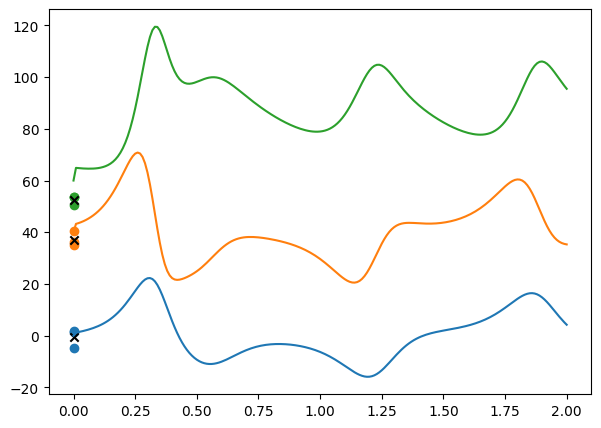

In [41]:
off = 0, 40, 50

x = np.linspace(0, dt*nstop, nstop+1)
wtrue = np.copy(xtrue)
wtrue[:, 1] += off1            
wtrue[:, 2] += off2
fig, ax = plt.subplots(figsize=[7, 5])
ax.plot(x, wtrue)
xf = np.load("xf000.npy")
xf_mean = np.mean(xf, axis=1)
ax.set_prop_cycle(None)
for i in range(len(off)):
    ax.scatter([0]*nmem, xf[i, :] + off[i])
for i in range(len(off)):
    ax.scatter(0, xf_mean[i] + off[i], c="black", marker="x")
for j in range(nstop//obs_int):
    ax.set_prop_cycle(None)
    xf = np.load(f"xf{obs_int*(j+1):03}.npy")
    xf_mean = np.mean(xf, axis=1)
    xa = np.load(f"xa{obs_int*(j+1):03}.npy")
    xa_mean = np.mean(xa, axis=1)
    t = obs_int*(j+1) * dt
    tnmem = [t] * nmem
    for i in range(len(off)):
        ax.scatter(tnmem, xf[i, :] + off[i])
    for i in range(len(off)):
        ax.scatter(t, xa_mean[i] + off[i], c="red")
    for i in range(len(off)):
        ax.scatter(t, xf_mean[i] + off[i], c="black", marker="x")

In [42]:
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

nh = 25
nn = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=[nh]))

In [43]:
from scipy.integrate import odeint


p, r, b, dt, nstop = 10.0, 32.0, 8/3, 0.01, 10000
w0 = np.array([1.0, 3.0, 5.0])
w1 = np.copy(w0)

def florenz_(w, t, p, r, b):
    return florenz(w, p, r, b)

w = odeint(florenz_, w1, np.linspace(0, 100, 10001), args=(p, r, b))

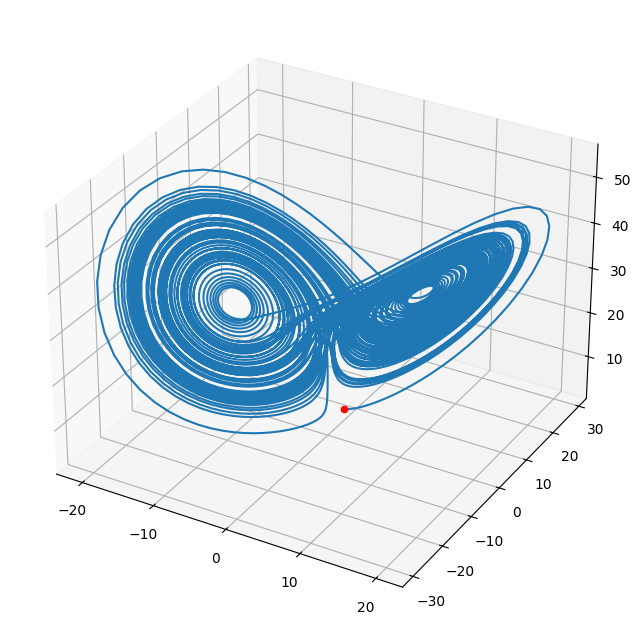

In [44]:
fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(projection="3d")
ax.scatter(*w[0,:], c="red")
ax.plot(*w.transpose())
plt.show()

In [45]:
dwdt = (w[1:] - w[:-1]) / dt
n_learn = int(nstop * 0.7)
nn.fit(w[1:n_learn+1], dwdt[0:n_learn])

c:\Users\hamma\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor', MLPRegressor(hidden_layer_sizes=[25]))])

In [46]:
w0  + dt * nn.predict(w0[None,])


array([[1.14011603, 3.24268967, 4.80629197]])

In [47]:
w[1,]


array([1.20279516, 3.26650983, 4.90248242])

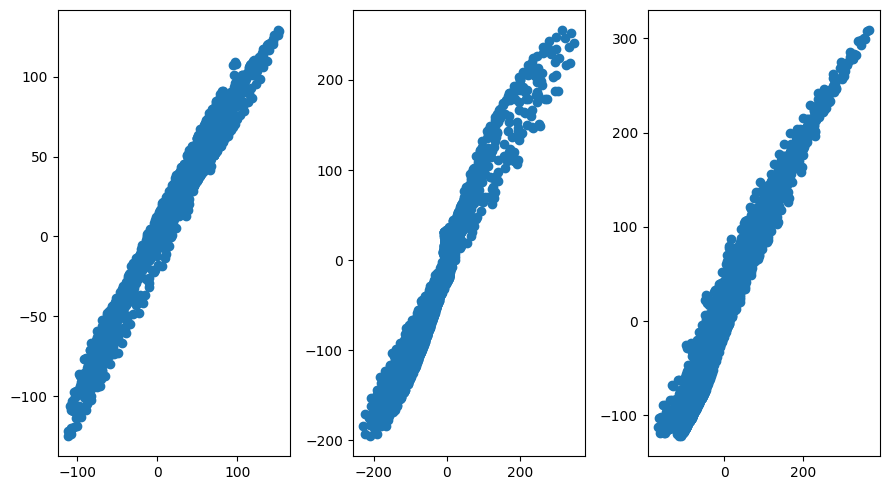

In [48]:
dwdt_nn = nn.predict(w[n_learn:-1])

fig, ax = plt.subplots(ncols = 3, figsize=[9, 5])
for i in range(w0.size):
    ax[i].scatter(dwdt[n_learn:, i], dwdt_nn[:, i])
fig.tight_layout()
plt.show()

In [49]:
np.linalg.norm(dwdt[n_learn:,:]-dwdt_nn) / np.linalg.norm(dwdt[n_learn:,:])

0.20293108436233037

In [50]:
from scipy.integrate import odeint

def florenz_nn(x, args):
    return nn.predict(x[None,]).ravel()

w_nn = odeint(florenz_nn, w0, np.linspace(0, 100, 10001))

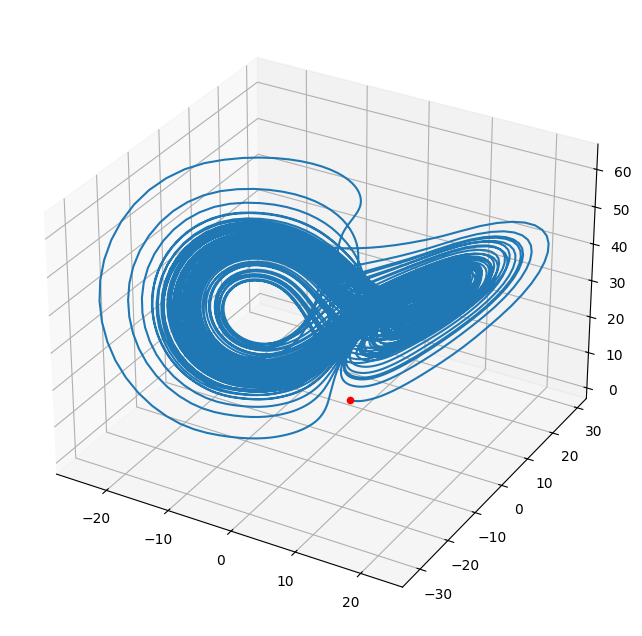

In [51]:
fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(projection="3d")
ax.scatter(*w0, c="red")
ax.plot(*w_nn.transpose())
plt.show()